In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
from scipy.stats import norm
from scipy.stats import t

In [3]:
sample_a = pd.read_csv('data/ab_test-redesign_sample_a.csv')
sample_b = pd.read_csv('data/ab_test-redesign_sample_b.csv')

In [4]:
sample_a

,date,cid,transactions,revenue,group
0,2020-11-06,1.001648e+09,0,0,A
1,2020-11-06,1.001936e+09,0,0,A
2,2020-11-06,1.003214e+08,0,0,A
3,2020-11-06,1.004393e+09,0,0,A
4,2020-11-06,1.006382e+09,0,0,A
...,...,...,...,...,...
61566,2020-11-23,9.986289e+08,0,0,A
61567,2020-11-23,9.989196e+08,0,0,A
61568,2020-11-23,9.990631e+08,0,0,A
61569,2020-11-23,9.994210e+07,0,0,A


In [5]:
sample_b

,date,cid,transactions,revenue,group
0,2020-11-06,1.000135e+09,0,0,B
1,2020-11-06,1.001648e+09,0,0,B
2,2020-11-06,1.003214e+08,0,0,B
3,2020-11-06,1.003652e+09,0,0,B
4,2020-11-06,1.003833e+09,0,0,B
...,...,...,...,...,...
61378,2020-11-23,9.965675e+08,0,0,B
61379,2020-11-23,9.970803e+07,0,0,B
61380,2020-11-23,9.984814e+08,0,0,B
61381,2020-11-23,9.991118e+08,0,0,B


In [6]:
sample_a['date'] = pd.to_datetime(sample_a['date'], format='%Y-%m-%d')
sample_b['date'] = pd.to_datetime(sample_b['date'], format='%Y-%m-%d')

In [7]:
daily_data_a = sample_a.groupby('date').agg({
    'cid':'count',
    'transactions':'sum',
    'revenue': 'sum'
}).reset_index().rename(columns={'cid': 'users_count'})
daily_data_a.head()

,date,users_count,transactions,revenue
0,2020-11-06,2576,16,1577279
1,2020-11-07,2704,23,1721886
2,2020-11-08,3354,25,846051
3,2020-11-09,3234,18,708830
4,2020-11-10,3022,29,826984


In [8]:
daily_data_b = sample_b.groupby('date').agg({
    'cid':'count',
    'transactions':'sum',
    'revenue': 'sum'
}).reset_index().rename(columns={'cid': 'users_count'})
daily_data_b.head()

,date,users_count,transactions,revenue
0,2020-11-06,2499,19,996645
1,2020-11-07,2804,19,555499
2,2020-11-08,3291,24,3044842
3,2020-11-09,3062,25,1285836
4,2020-11-10,3072,30,2414726


In [9]:
daily_data_a[daily_data_a['date'] == '2020-11-08']

,date,users_count,transactions,revenue
2,2020-11-08,3354,25,846051


In [10]:
daily_data_a['cum_users_count'] = daily_data_a['users_count'].cumsum()
daily_data_a['cum_transact'] = daily_data_a['transactions'].cumsum()
daily_data_a['cum_rev'] = daily_data_a['revenue'].cumsum()

daily_data_a['cum_conv'] = daily_data_a['cum_transact'] / daily_data_a['cum_users_count'] * 100
daily_data_a['cum_avg_check'] = daily_data_a['cum_rev'] / daily_data_a['cum_transact']

daily_data_a.head()

,date,users_count,transactions,revenue,cum_users_count,cum_transact,cum_rev,cum_conv,cum_avg_check
0,2020-11-06,2576,16,1577279,2576,16,1577279,0.621118,98579.937500
1,2020-11-07,2704,23,1721886,5280,39,3299165,0.738636,84593.974359
2,2020-11-08,3354,25,846051,8634,64,4145216,0.741256,64769.000000
3,2020-11-09,3234,18,708830,11868,82,4854046,0.690934,59195.682927
4,2020-11-10,3022,29,826984,14890,111,5681030,0.745467,51180.450450


In [11]:
daily_data_b['cum_users_count'] = daily_data_b['users_count'].cumsum()
daily_data_b['cum_transact'] = daily_data_b['transactions'].cumsum()
daily_data_b['cum_rev'] = daily_data_b['revenue'].cumsum()

daily_data_b['cum_conv'] = daily_data_b['cum_transact'] / daily_data_b['cum_users_count'] * 100
daily_data_b['cum_avg_check'] = daily_data_b['cum_rev'] / daily_data_b['cum_transact']

daily_data_b.head()

,date,users_count,transactions,revenue,cum_users_count,cum_transact,cum_rev,cum_conv,cum_avg_check
0,2020-11-06,2499,19,996645,2499,19,996645,0.760304,52455.000000
1,2020-11-07,2804,19,555499,5303,38,1552144,0.716576,40845.894737
2,2020-11-08,3291,24,3044842,8594,62,4596986,0.721434,74144.935484
3,2020-11-09,3062,25,1285836,11656,87,5882822,0.746397,67618.643678
4,2020-11-10,3072,30,2414726,14728,117,8297548,0.794405,70919.213675


In [12]:
print(round(daily_data_a['cum_conv'].mean(), 2), round(daily_data_b['cum_conv'].mean(), 2), sep='\n')

0.71
0.76


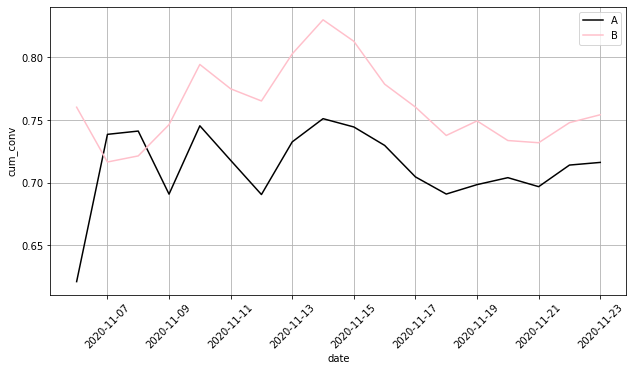

In [13]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([1, 1, 1, 1])
sns.lineplot(x='date', y='cum_conv', data=daily_data_a, ax=ax, color='black')
sns.lineplot(x='date', y='cum_conv', data=daily_data_b, ax=ax, color='pink')
ax.xaxis.set_tick_params(rotation = 45)
ax.legend(['A', 'B'])
ax.grid();

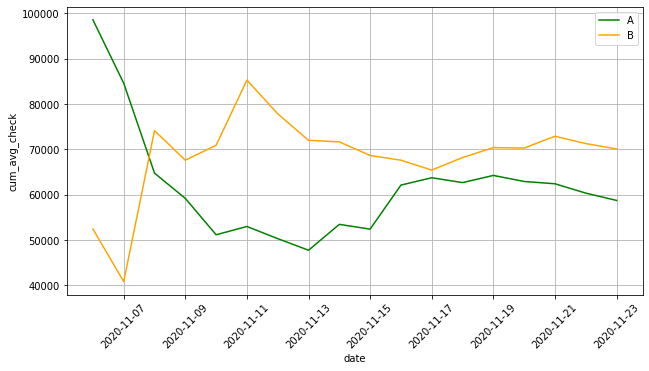

In [14]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([1, 1, 1, 1])
sns.lineplot(x='date', y='cum_avg_check', data=daily_data_a, ax=ax, color='green')
sns.lineplot(x='date', y='cum_avg_check', data=daily_data_b, ax=ax, color='orange')
ax.xaxis.set_tick_params(rotation = 45)
ax.legend(['A', 'B'])
ax.grid();

In [15]:
H0 = 'Конверсии в группах равны'
H1 = 'Конверсия в группе А меньше, чем конверсия в группе B'

alpha = 0.1

_, p_value = proportions_ztest(
    count=[sample_a.transactions.sum(), sample_b.transactions.sum()],
    nobs=[sample_a.cid.count(), sample_b.cid.count()],
    alternative='smaller'
)

print('p-value: ', round(p_value, 2))

if p_value < alpha:
    print(f'Отвергаем нулевую гипотезу. {H0}')
    print(f'Альтернативная гипотеза. H1: {H1}')
else:
    print(f'Принимаем нулевую гипотезу. {H0}')

p-value:  0.22
Принимаем нулевую гипотезу. Конверсии в группах равны


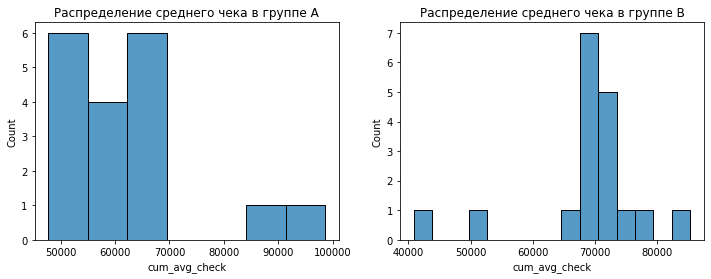

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
#строим гистограмму для времени на сайте в каждой группе
sns.histplot(x='cum_avg_check', data=daily_data_a, ax=axes[0])
sns.histplot(x='cum_avg_check', data=daily_data_b, ax=axes[1])
#задаём названия графикам
axes[0].set_title('Распределение среднего чека в группе А');
axes[1].set_title('Распределение среднего чека в группе B');

In [17]:
H0 = 'Распределения в обеих группах нормальные'
H1 = 'Распределение в одной или обеих группах отлично от нормального'

alpha = 0.1

shapiro_result_a = shapiro(daily_data_a['cum_avg_check'])
shapiro_result_b = shapiro(daily_data_b['cum_avg_check'])

print('p-value группы А', round(shapiro_result_a.pvalue, 4))
print('p-value группы B', round(shapiro_result_b.pvalue, 4))

if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
    print(f'Отвергаем нулевую гипотезу. {H0}')
    print(f'Альтернативная гипотеза. H1: {H1}')
else:
    print(f'Принимаем нулевую гипотезу. {H0}')

p-value группы А 0.0011
p-value группы B 0.0016
Отвергаем нулевую гипотезу. Распределения в обеих группах нормальные
Альтернативная гипотеза. H1: Распределение в одной или обеих группах отлично от нормального


In [18]:
H0 = 'Ежедневные средние чеки в группах равны'
H1 = 'Ежедневный средний чек в группе А меньше, чем в группе B'

alpha = 0.1

results = mannwhitneyu(
    daily_data_a['revenue'], 
    daily_data_b['revenue'], 
    alternative='less'
)

print('p-value: ', round(results.pvalue, 2))

if results.pvalue < alpha:
    print(f'Отвергаем нулевую гипотезу. {H0}')
    print(f'Альтернативная гипотеза. H1: {H1}')
else:
    print(f'Принимаем нулевую гипотезу. {H0}')

p-value:  0.06
Отвергаем нулевую гипотезу. Ежедневные средние чеки в группах равны
Альтернативная гипотеза. H1: Ежедневный средний чек в группе А меньше, чем в группе B


In [22]:
def get_confidence_interval_with_std(n, x_mean, sigma, gamma, rounding=2): # n - размер выборки, x_mean - выборочное среднее, sigma - истинное std, gamma - уровень надёжности, rounding - число знаков после зпт
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    
    eps = z_crit * sigma/(n ** 0.5) #погрешность
    lower_bound = x_mean - eps # левая (нижняя) граница
    upper_bound = x_mean + eps # правая (верхняя) граница
    confidence_interval = (round(lower_bound, rounding), round(upper_bound, rounding)) # создание кортежа из округлённых границ интервала
    
    print(f'Доверительный интервал: {confidence_interval}')
    return confidence_interval
    

In [23]:
def get_confidence_interval_without_std(n, x_mean, x_std, gamma, rounding=2): # n - размер выборки, x_mean - выборочное среднее, x_std - выборочное std, gamma - уровень надёжности, rounding - число знаков после зпт
    k = n - 1 # число степеней свободы
    alpha = 1 - gamma # уровень значимости
    t_crit = -t.ppf(alpha/2, k) # t-критическое
    
    eps = t_crit * x_std/(n ** 0.5) # погрешность
    lower_bound = x_mean - eps # левая (нижняя) граница
    upper_bound = x_mean + eps # правая (верхняя) граница
    confidence_interval = (round(lower_bound, rounding), round(upper_bound, rounding)) # создание кортежа из округлённых границ интервала
    
    print(f'Доверительный интервал: {confidence_interval}')
    return confidence_interval

In [27]:
def proportions_conf_interval(n, x_p, gamma): # n - размер выборки, x_p - выборочная пропорция, gamma - уровень надёжности   
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 #погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    confidence_interval = (round(lower_bound * 100, 2), round(upper_bound * 100, 2)) # создание кортежа из округлённых границ интервала
    
    print(f'Доверительный интервал для конверсии группы: {confidence_interval}')
    return confidence_interval

In [28]:
def diff_proportions_conf_interval(n, xp, gamma=0.95): # n — список из размеров выборки для гр. А и B соотв., xp — список из выб. проп. для гр. А и B соотв., gamma — уровень надёжности
    alpha = 1 - gamma # уровень значимости
    diff = xp[1] - xp[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    confidence_interval = (round(lower_bound * 100, 2), round(upper_bound * 100, 2)) # создание кортежа из округлённых границ интервала
    
    print(f'Доверительный интервал  для разности конверсий: {confidence_interval}')
    return confidence_interval